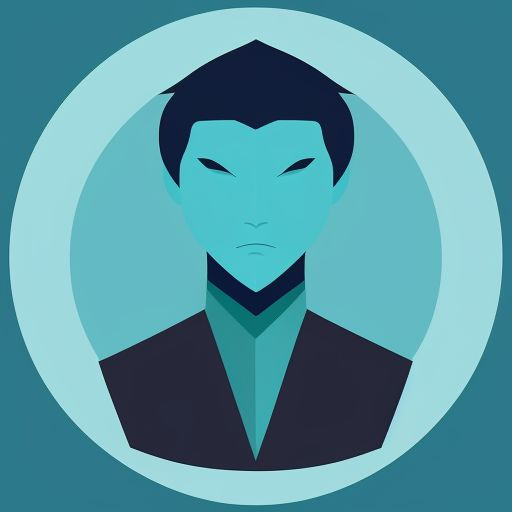

In [1]:
from PIL import Image
image = Image.open("human_avatar.jpeg")
image

In [2]:
import ollama

In [3]:
for chunk in ollama.chat(
    model="phi3",
    messages=[
        {"role":"system","content":"answer only with 'yes' or 'no'"},
        {"role":"user","content":input("give your qiestion:")},
    ],
    stream=True
):
    print(chunk["message"]["content"], end="", flush=True)

 Yes.

Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


image_path:
'C:\\Users\\Yahia\\AppData\\Local\\Temp\\gradio\\0c8f6b65cb1f0eefe6b626dbce256a82beef1463\\image.png'
[HumanMessage(content=[{'type': 'text', 'text': '\nTask: Generate an image prompt or object detection parameters from a fully detailed description. The prompt or parameters should be accurate and complete, and should be in a format that is compatible with Image Generation models\n'}, {'type': 'image_url', 'image_url': ''}])]
Keyboard interruption in main thread... closing server.

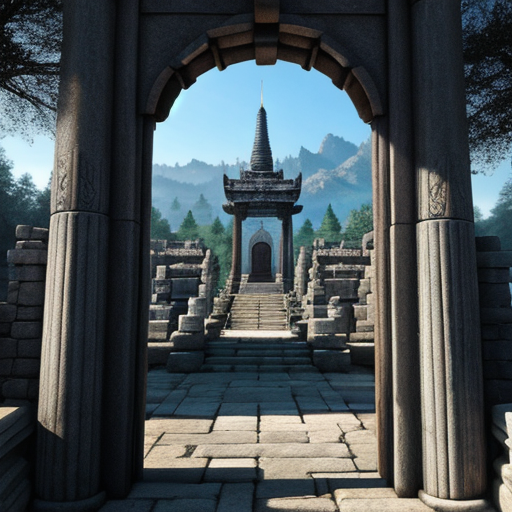

In [2]:
import os
from pathlib import Path
from pprint import pprint
from typing import List
import ollama
import gradio as gr

import torch
from diffusers import StableDiffusion3Pipeline, AutoencoderTiny
from diffusers import StableDiffusionPipeline

from PIL import Image
import io  # Import the io module for working with in-memory byte streams
import base64  # Import the base64 module for encoding and decoding
from transformers import T5EncoderModel, BitsAndBytesConfig

from langchain_community.llms.ollama import Ollama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain.prompts import (
    PromptTemplate,
    HumanMessagePromptTemplate,
    ChatPromptTemplate,
    MessagesPlaceholder,
)

from langchain.memory import ConversationBufferMemory, FileChatMessageHistory

from langchain_community.embeddings.ollama import OllamaEmbeddings
from langchain.chains import LLMChain
from langchain.chains.summarize import load_summarize_chain
from langchain.chains import RetrievalQA
from langchain_community.vectorstores.chroma import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.document_loaders import TextLoader, PyPDFLoader, Docx2txtLoader

from dotenv import load_dotenv, find_dotenv
from google.colab import userdata

load_dotenv(find_dotenv(), override=True)

os.environ["GOOGLE_API_KEY"] = userdata.get("GOOGLE_API_KEY")
phi_llm = Ollama(model="phi3", temperature=0.7)

# TEXT GEN AND IMAGE VIS Models INIT
google_llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=0.7)  # type: ignore
google_vision_llm = ChatGoogleGenerativeAI(model="gemini-pro-vision", temperature=0)  # type: ignore
formatting_prompt_template = ChatPromptTemplate.from_messages(
    [
        HumanMessagePromptTemplate.from_template(
            """prettify the following output in a gorgeous markdown format(keep the langauge as it is wherever you find it, jus do the prettifying):
{text}
"""
        )
    ]
)

formatter_chain = LLMChain(
    llm=google_llm, prompt=formatting_prompt_template, verbose=True
)
qachain = None
sumerization_chain = None
conversation_chain = None
# IMAGE GENERATION MODEL CONFIG FOR PERFORMANCE
quantization_config = BitsAndBytesConfig(load_in_8bit=True)
model_ids = {
    "Overall": {
        "name": "stabilityai/stable-diffusion-xl-base-1.0",
        "downloaded": False,
    },
    "Realistic": {
        "name": "SG161222/Realistic_Vision_V6.0_B1_noVAE",
        "downloaded": False,
    },
    "Photographic": {"name": "emilianJR/epiCRealism", "downloaded": False},
    "Analogue": {"name": "wavymulder/Analog-Diffusion", "downloaded": False},
    "Photoreal": {"name": "stablediffusionapi/AbsoluteReality", "downloaded": False},
    "Anime": {"name": "stablediffusionapi/anything-v5", "downloaded": False},
    "Fantasy": {"name": "Lykon/DreamShaper", "downloaded": False},
    "Midjourney-alternative": {"name": "prompthero/openjourney", "downloaded": False},
    "Mix": {"name": "emilianJR/majicMIX_realistic_v6", "downloaded": False},
    "Best SDXL": {"name": "RunDiffusion/Juggernaut-XL-v9", "downloaded": False},
}
# model_id = "stabilityai/stable-diffusion-3-medium-diffusers"
# model_id = "emilianJR/majicMIX_realistic_v6"
# text_encoder = T5EncoderModel.from_pretrained(
#     model_id,
#     subfolder="text_encoder_3",
#     quantization_config=quantization_config,
# )
# pipe = StableDiffusion3Pipeline.from_pretrained(
# pipe = StableDiffusionPipeline.from_pretrained(
#     model_id,
#     safety_checker=None,
#     # text_encoder_3=text_encoder,
#     # device_map="balanced",
#     torch_dtype=torch.float16,
# )

# using a tiny variational auto encoder for instant latent space into pixel space decode
# pipe.vae = AutoencoderTiny.from_pretrained("madebyollin/taesd3", torch_dtype=torch.float16)
# pipe.vae.config.shift_factor = 0.0


# WORKFLOWS ACRONYMS
workflows_endonyms = {
    "Image to Text": "image2text",
    "Text to Image": "text2image",
    "Text to Text": "text2text",
    "Audio to Text": "audio2text",
    "Text to Audio": "text2audio",
}
workflow_tasks = {
    "image2text": [
        "image description",
        "extract text from image",
        "color pallet extraction",
    ],
    "text2image": [
        "image creation",
        "image edition",
        "inpainting",
        "image scaling",
        "image resolution fixing",
    ],
    "text2text": [
        "programming",
        "fixing programs",
        "conversation",
        "translation",
        "summerization",
        "question answer",
    ],
}


def bot_logic(
    msg: dict,
    history: List[List[str]],
    api_key: str,
    system_prompt: str,
    temperature: float,
    conversation_history: bool,
    provider: str,
    workflow: str,
    task: str,
    style: str,
    negative_prompt: str,
    guidance_scale: float,
    steps: int,
    seeds: int,
    width: int,
    height: int,
    format: str,
    save_image: bool,
    top_k: int,
    chunk_size: int,
    chunk_overlap: int,
    summerization_algorithm: str,
):
    os.environ["GOOGLE_API_KEY"] = api_key
    workflow = workflows_endonyms.get(workflow, "")
    tasks = workflow_tasks.get(workflow, [])
    if not workflow:
        raise gr.Error(
            "invalid workflow choose a different one form the workflows list in the advances section below"
        )

    if not tasks:
        raise gr.Error(
            f"invalid task not in the category {workflow} choose a different one between {workflow_tasks[workflow]} form the tasks list in the advances section below"
        )
    history_langchain_format = []
    global phi_llm
    global google_llm
    global google_vision_llm
    global formatter_chain
    global qachain
    global sumerization_chain
    global conversation_chain
    phi_llm.temperature = temperature
    google_llm.temperature = temperature

    messages = []
    try:

        if history:
            for human, ai in history:
                print(human, ai)
                gr.Info(f"human: {human} ai: {ai}")
                history_langchain_format.append(
                    HumanMessage(content=human if human else "")
                )
                history_langchain_format.append(AIMessage(content=ai if ai else ""))
        match workflow:
            # IMAGE TO TEXT WORKFLOW TASKS
            case "image2text":

                def _image_deliver() -> List[str]:

                    image_path = msg["files"][0]
                    image_name, ext = os.path.splitext(image_path)
                    print("image_path:")
                    pprint(image_path)
                    image = Image.open(image_path)

                    buffered = io.BytesIO()
                    image.save(buffered, format=ext.upper().replace(".", ""))
                    img_str = base64.b64encode(buffered.getvalue()).decode()
                    return img_str, ext.replace(".", "")  # type: ignore

                match task:
                    case "image description":
                        img_str, ext = _image_deliver()
                        messages = [
                            HumanMessage(
                                content=[
                                    {
                                        "type": "text",
                                        "text": """
  Task: Generate an image prompt or object detection parameters from a fully detailed description. The prompt or parameters should be accurate and complete, and should be in a format that is compatible with Image Generation models
  """,
                                    },
                                    {
                                        "type": "image_url",
                                        "image_url": f"data:image/{ext};base64,{img_str}",
                                    },  # Pass the base64 encoded image as a string
                                    # {"type": "image_url", "image_url": image},
                                ]
                            )
                        ]

                    case "extract text from image":
                        img_str, ext = _image_deliver()

                        messages = [
                            HumanMessage(
                                content=[
                                    {
                                        "type": "text",
                                        "text": """
  Task: Extract text from the provided image file. The text should be accurate and complete, and it should be formatted in a way that is easy to read and understand.

  Input: The input to the system will be an image file. The image file can be in any common format, such as JPEG, PNG, or TIFF.

  Output: The output of the system will be a textual output  containing the extracted text. The output should be encoded in UTF-8 format.
                                      """,
                                    },
                                    {
                                        "type": "image_url",
                                        "image_url": f"data:image/{ext};base64,{img_str}",
                                    },  # Pass the base64 encoded image as a string
                                    # {"type": "image_url", "image_url": image},
                                ]
                            )
                        ]

                    case "color pallet extraction":
                        img_str, ext = _image_deliver()

                        messages = [
                            HumanMessage(
                                content=[
                                    {
                                        "type": "text",
                                        "text": """
  Task: Extract the dominant colors or color palette from the provided image.
  The colors should be accurately represented and should be in a format that is easy to use and understand.


  Output:
      - LIST OF HEX OR RGBA OR HSL, with each color in front of it's suggested name.
      - categorise the colors into the contextual colors in bootstrap framework(PRIMARY, SECONDARY, INFO, WARNING, DANGER, SUCCESS, DARK, LIGHT, BLACK, WHITE).
  """,
                                    },
                                    {
                                        "type": "image_url",
                                        "image_url": f"data:image/{ext};base64,{img_str}",
                                    },  # Pass the base64 encoded image as a string
                                    # {"type": "image_url", "image_url": image},
                                ]
                            )
                        ]

                history_langchain_format.extend(messages)
                pprint(messages)
                total_response = ""

                for chunk in formatter_chain.stream(
                    google_vision_llm.invoke(messages).content  # type: ignore
                ):

                    pprint(chunk)
                    print(chunk["text"], end="", flush=True)
                    total_response += chunk["text"]
                    yield total_response

            # IMAGE GEN WORKFLOW TASKS
            case "text2image":
                model_id_info = model_ids.get(style, "")
                if not model_id_info:
                    raise gr.Error(
                        "invalid style choose a different one form the styles list in the advances section below"
                    )
                model_id = model_id_info.get("name", "")  # type: ignore
                gr.Info(f"the chosen style is {style} with the model {model_id}")

                pipe = StableDiffusionPipeline.from_pretrained(
                    model_id,
                    # text_encoder_3=text_encoder,
                    # device_map="balanced",
                    torch_dtype=torch.float16,
                    safety_checker=None,
                )
                pipe = pipe.to("cuda")
                pipe.safety_checker = None
                pipe.requires_safety_checker = False
                model_id_info["downloaded"] = True  # type: ignore
                if not model_id_info["downloaded"]:  # type: ignore
                    raise gr.Error(
                        f"the model {model_id} hasn't been downlaoded yet try again!"
                    )
                match task:
                    case "image creation":
                        image = pipe(
                            prompt=msg["text"],
                            negative_prompt=negative_prompt,
                            guidance_scale=guidance_scale,
                            num_inference_steps=steps,
                            width=width,
                            height=height,
                            generator=torch.Generator("cuda").manual_seed(seeds),
                        ).images[0]

                    case "image edition":
                        image = pipe(
                            prompt=msg["text"],
                            negative_prompt=negative_prompt,
                            guidance_scale=guidance_scale,
                            num_inference_steps=steps,
                            width=width,
                            height=height,
                            generator=torch.Generator("cuda").manual_seed(seeds),
                            init_image=Image.open(msg["files"][0]),
                        ).images[0]

                    case "inpainting":
                        gr.Warning("not implemented yet")
                    case "image scaling":
                        gr.Warning("not implemented yet")
                    case "image resolution fixing":
                        gr.Warning("not implemented yet")

                if not save_image:
                    image_name = f".image.{format.lower()}"
                    gr.Info(f"created the image {image_name}")
                else:
                    image_name = f"image.{format.lower()}"

                image.save(image_name)
                # Assuming 'image' is your PIL Image object
                # buffered = io.BytesIO()
                # image.save(buffered, format=format)  # Or another suitable format
                # img_str = base64.b64encode(buffered.getvalue()).decode()
                yield (
                    Path(
                        image_name
                    ),  # Yield the base64 encoded image URL as a dictionary
                    msg["text"],  # Yield the text message as a dictionary
                )
            # TEXT GEN WORKFLOW TASKS
            case "text2text":
                if msg["files"]:
                    filepath, ext = os.path.splitext(msg["files"][0])
                    history = []
                    raise gr.Error(
                        f"Choose a Workflow suitable for the {ext} file types"
                    )
                else:
                    match task:
                        case "programming":
                            default_system_prompt = f"""write me the code for:
      {msg["text"]}
      """
                        case "fixing programs":
                            default_system_prompt = f"""write me the code for:
      {msg["text"]}
      """
                        case "conversation":
                            default_system_prompt = f"""
  Instructions: Engage in a natural and coherent conversation with the user on the topic of the user.
  Respond appropriately and provide informative or engaging responses that keep the conversation going.
  Do not: Use offensive or harmful language. Do not impersonate a real person. Do not share personal or confidential information.
  Additional notes: You may use emojis or other non-verbal cues to enhance the conversation. If you are unsure how to respond, please ask for clarification
  """
                            (
                                history_langchain_format.append(
                                    ("system", default_system_prompt)
                                )
                                if provider == "ollama"
                                else None
                            )
                            #                     if "GOOGLE_API_KEY" in os.environ:
                            #                         llm = ChatGoogleGenerativeAI(model="gemini-pro", temperature=temperature) # type: ignore
                            # appending the human prompt to the to the langchain messages to be sent to the conversational bot llm

                            history_langchain_format.append(
                                (
                                    "human",
                                    (
                                        msg["text"]
                                        if provider == "ollama"
                                        else default_system_prompt + msg["text"]
                                    ),
                                )
                            )
                            # check if there is a previous chat history file

                            if os.path.exists("chat_history.json"):
                                memory = ConversationBufferMemory(
                                    memory_key="chat_history",
                                    chat_memory=FileChatMessageHistory(
                                        "chat_history.json"
                                    ),
                                    return_messages=True,
                                )

                                prompt_template = """{content}"""
                                prompt = ChatPromptTemplate(
                                    input_variables=["content"],
                                    messages=[
                                        MessagesPlaceholder(
                                            variable_name="chat_history"
                                        ),
                                        HumanMessagePromptTemplate.from_template(
                                            template=prompt_template
                                        ),
                                    ],
                                )
                            # check if any conversation chain is already set
                            if not conversation_history:
                                # PART ONE: INITIALIZING THE CONVERSATION CHAIN
                                gr.Info(
                                    f"starting initializing the conversation chain...."
                                )
                                conversation_chain = LLMChain(
                                    llm=phi_llm if provider == "ollama" else google_llm,
                                    prompt=prompt,
                                    memory=memory,
                                    verbose=True,
                                )
                                # executing the chain to answer the question based on the previous chat history

                            total_response = ""
                            for chunk in conversation_chain.stream(  # type: ignore
                                history_langchain_format
                            ):

                                print(chunk, end="", flush=True)
                                total_response += chunk
                                yield total_response
                            if not conversation_history:
                                match provider:
                                    case "google":
                                        if "GOOGLE_API_KEY" in os.environ:

                                            prompt = PromptTemplate.from_template(
                                                f"{default_system_prompt}\n {prompt_template}"
                                            )
                                            formatted_prompt = prompt.format(
                                                message=msg["text"],
                                                system_prompt=system_prompt,
                                            )
                                            history_langchain_format.append(
                                                formatted_prompt
                                            )
                                            pprint(history_langchain_format)
                                            total_response = ""
                                            for chunk in google_llm.stream(
                                                history_langchain_format
                                            ):

                                                print(chunk, end="", flush=True)
                                                total_response += chunk.content  # type: ignore
                                                yield total_response
                                        else:
                                            raise gr.Error(
                                                "Provide the Google API key to continue"
                                            )

                                    case "ollama":
                                        history_ollama_format = []
                                        for human, ai in history:
                                            history_ollama_format.append(
                                                {"role": "user", "content": f"{human}"}
                                            )
                                            history_ollama_format.append(
                                                {"role": "ai", "content": f"{ai}"}
                                            )
                                        history_ollama_format.append(
                                            {
                                                "role": "system",
                                                "content": default_system_prompt
                                                + system_prompt,
                                            }
                                        )
                                        history_ollama_format.append(
                                            {"role": "user", "content": msg["text"]}
                                        )
                                        total_response = ""
                                        for chunk in ollama.chat(
                                            model="phi3",
                                            messages=history_ollama_format,
                                            stream=True,
                                        ):
                                            print(
                                                chunk["message"]["content"],  # type: ignore
                                                end="",
                                                flush=True,
                                            )
                                            total_response += chunk["message"][  # type: ignore
                                                "content"
                                            ]
                                            yield total_response

                        case "translation":

                            translation_prompt_template = ChatPromptTemplate.from_messages(
                                [
                                    HumanMessagePromptTemplate.from_template(
                                        """
  write a concise translation of the given text commentaries, while keeping the code or any Entities (country names, person names, organisations, acronyms etc) in it's original langauge (basically codes are written in english):
  translate the following text:
  TEXT:{text}
  into {langauge}
  """
                                    )
                                ]
                            )

                            translation_chain = LLMChain(
                                llm=google_llm,
                                prompt=translation_prompt_template,
                                verbose=True,
                            )

                            total_response = ""
                            for chunk in formatter_chain.stream(
                                translation_chain.invoke(
                                    {"text": msg["text"], "langauge": "arabic"}
                                )
                            ):

                                print(chunk, end="", flush=True)
                                total_response += chunk["text"]
                                yield total_response

                        case "summerization":
                            # check if the summerization chain is initialized otherwise skipping to the summerization part
                            if not sumerization_chain:
                                # PART ONE: FETCHING DOCUMENT
                                url = msg["files"][0]
                                if not os.path.exists(url):
                                    raise FileNotFoundError(
                                        f"file {url} doesn't exist!"
                                    )

                                filename, ext = os.path.splitext(url)
                                print("filename, ext:")
                                print(filename, ext)

                                gr.Info(f"started loading docs ...")
                                match ext.replace(".", ""):

                                    case "md" | "txt":

                                        print("This is a markdown or textual file")

                                        loader = TextLoader(url)

                                    case "pdf":

                                        loader = PyPDFLoader(url)

                                        print("This is a pdf file")

                                    case "docx" | "doc" | "odt":

                                        loader = Docx2txtLoader(url)

                                        print("This is a word document file")

                                    case _:
                                        raise gr.Error(
                                            f"This is an unknown file type ,extention {ext} not supported"
                                        )

                                documents = loader.load()
                                gr.Info(f"Loaded all {msg['files']} successfully")
                                pprint(documents[:3])
                                chunks = RecursiveCharacterTextSplitter(
                                    chunk_size=chunk_size, chunk_overlap=chunk_overlap
                                ).split_documents(documents)
                                gr.Info(f"chunking completed successfully")
                                pprint(chunks[:3])
                                # PART TWO: initializing the summerization chain
                                sumerization_chain = load_summarize_chain(
                                    llm=phi_llm,
                                    chain_type=summerization_algorithm,
                                    verbose=True,
                                )

                            summary = (
                                sumerization_chain.run(chunks)
                                if sumerization_chain
                                else gr.Info("summary chain not initialized")
                            )
                            gr.Info(f"summerization completed successfully")
                            pprint(summary[:50])  # type: ignore
                            yield summary

                        case "question answer":
                            # check for the question answer chain qachain existence if there is a qachain then there is no need for the initializaion pipeline and could directly skip to chat mode
                            if not qachain:
                                # PART ONE: LOADING FILES
                                urls = msg["files"]
                                documents = []
                                for url in urls:
                                    if not os.path.exists(url):
                                        raise FileNotFoundError(
                                            f"file {url} doesn't exist!"
                                        )

                                    filename, ext = os.path.splitext(url)
                                    print("filename, ext:")
                                    print(filename, ext)

                                    gr.Info(f"started loading docs ...")
                                    match ext.replace(".", ""):

                                        case "md" | "txt":

                                            print("This is a markdown or textual file")

                                            loader = TextLoader(url)

                                        case "pdf":

                                            loader = PyPDFLoader(url)

                                            print("This is a pdf file")

                                        case "docx" | "doc" | "odt":

                                            loader = Docx2txtLoader(url)

                                            print("This is a word document file")

                                        case _:
                                            raise gr.Error(
                                                f"This is an unknown file type ,extention {ext} not supported"
                                            )

                                    documents += loader.load()
                                gr.Info(f"Loaded all {msg['files']} successfully")
                                pprint(documents[:3])

                                # PART TWO: SPLITTING INTO CHUNKS
                                gr.Info(f"started chunking ...")
                                text_splitter = RecursiveCharacterTextSplitter(
                                    chunk_size=chunk_size, chunk_overlap=chunk_overlap
                                )
                                print("text_splitter:")
                                pprint(text_splitter)
                                extracted_text = "\n".join(
                                    [page.page_content for page in documents]
                                )
                                print("extracted_text:")
                                pprint(extracted_text[:50])
                                chunks = text_splitter.split_text(extracted_text)

                                print("chunks:")
                                gr.Info(f"chunking completed successfully")
                                pprint(chunks[:3])

                                # PART THREE: EMBEDDING
                                gr.Info(f"starting embedding ...")
                                embedder = OllamaEmbeddings(model="phi3")

                                vector_store = Chroma.from_texts(chunks, embedder)

                                print("vector_store:")

                                gr.Info(f"embedding completed successfully")
                                pprint(vector_store)

                                # PART FOUR: INITIALIZING THE CHAIN
                                gr.Info(f"started initializing ....")
                                qachain = RetrievalQA.from_chain_type(
                                    phi_llm,
                                    verbose=True,
                                    retriever=vector_store.as_retriever(
                                        search_type="similarity",
                                        search_kwargs={"k": top_k},
                                    ),
                                    chain_type="stuff",
                                    return_source_documents=True,
                                )
                                gr.Info(f"finished initializing successfully")
                                print(" QA chain:")
                                pprint(qachain)

                            with open("response.md", "w") as outfile:
                                total_response = ""
                                response = qachain.invoke(msg["text"])  # type: ignore
                                total_response += response.get("result")
                                print(response.get("result"), file=outfile)
                                for docid, doc in enumerate(
                                    response.get(
                                        "source_documents", "no source documents"
                                    )
                                ):
                                    total_response += f"\n### document number {docid}\n"
                                    total_response += doc.page_content
                                yield total_response
    except Exception as e:
        # showing the exception and the line in which it had occured
        raise gr.Error(f"{e.__class__.__name__}: {e}") from e


app = gr.ChatInterface(
    fn=bot_logic,
    multimodal=True,
    chatbot=gr.Chatbot(label="Chat Messages:"),
    textbox=gr.MultimodalTextbox(placeholder="your question:"),
    additional_inputs_accordion=gr.Accordion("Advanced:", open=False),
    additional_inputs=[
        gr.Textbox(label="Api key:", type="password", show_copy_button=True),
        gr.TextArea(
            label="System prompt:", placeholder="place your system prompt here"
        ),
        gr.Number(label="Creativity", maximum=1, minimum=0, value=0.7),
        gr.Checkbox(label="Conversation with previous history", value=False),
        gr.Radio(label="Provider", choices=["ollama", "google"], value="ollama"),
        gr.Dropdown(
            label="Workflows",
            choices=["Image to Text", "Text to Image", "Text to Text"],
            value="Text to Text",
        ),
        gr.Dropdown(
            label="Workflow Tasks",
            choices=[
                "image description",
                "extract text from image",
                "color pallet extraction",
                "image creation",
                "image edition",
                "inpainting",
                "image scaling",
                "image resolution fixing",
                "programming",
                "fixing programs",
                "conversation",
                "translation",
                "summerization",
                "question answer",
            ],
            value="conversation",
        ),
        gr.Radio(
            label="Style",
            choices=[
                "Overall",
                "Realistic",
                "Photographic",
                "Analogue",
                "Photoreal",
                "Anime",
                "fantasy",
                "Surrealism",
                "Mix",
                "Best SDXL",
            ],
            value="Mix",
        ),
        gr.Textbox(
            label="Negative Prompt",
            placeholder="place your negative prompt here",
            value="easynegative,,bad face,disfigured face,bad anatomy,lowres,text,error,missing finger,cross eyed,bad proportions,gross proportions,poorly drawn face,extra foot,extra leg,disfigured,blurry,extra arm,extra hand,missing leg,missing arm,deformed limb,polar lowres,bad body,mutated hands,long neck,cropped,poorley drawn hand,bad feet",
        ),
        gr.Slider(
            label="Guidance",
            minimum=0,
            maximum=1,
            step=0.1,
            value=0.7,
        ),
        gr.Number(
            label="Steps",
            minimum=0,
            maximum=50,
            step=1,
            value=25,
        ),
        gr.Number(
            label="Seeds",
            minimum=0,
            maximum=2147483647,
            step=1,
            value=42,
        ),
        gr.Number(
            label="width",
            minimum=0,
            maximum=4096,
            step=1,
            value=512,
        ),
        gr.Number(
            label="height",
            minimum=0,
            maximum=4096,
            step=1,
            value=512,
        ),
        gr.Radio(
            label="Format",
            choices=[
                "PNG",
                "JPEG",
            ],
            value="JPEG",
        ),
        gr.Checkbox(
            label="Save Image",
            value=False,
        ),
        gr.Number(
            label="top k result:",
            minimum=0,
            maximum=20,
            step=1,
            value=4,
        ),
        gr.Number(
            label="chunk size",
            minimum=0,
            maximum=4096,
            step=1,
            value=1000,
        ),
        gr.Number(
            label="chunk overlaping",
            minimum=0,
            maximum=4096,
            step=1,
            value=200,
        ),
        gr.Dropdown(
            label="summerization algorithm",
            choices=["stuff", "map_reduce", "refiner"],
            value="map_reduce",
        ),
    ],
)

app.launch(
    debug=True,
    share=True,
)